In [371]:
from ase.io import read, write
from ase.visualize import view
from ase import Atoms
from rdkit.Chem import AllChem as Chem
from rdkit.Chem import SanitizeMol
import networkx as nx
import numpy as np
import re
import math as m
import ase
print(ase.__version__)

3.23.0


In [372]:
#remove type information e.g 17(28) ..
def remove_type(text):
    pattern = r'\(.*?\)'
    result = re.sub(pattern, '', text)
    return result

#obtain bond list from input data bonds array
def Bonds(bond_lib):
    bond_list = []
    for index in range(len(bond_lib)):
        if bond_lib[index] == "_":
            pass
        else:
            bonds = bond_lib[index].split(',')
            for bond in bonds:
                bond_list.append([index, int(remove_type(bond))])
    return bond_list

#find neighbors for an atom
def find_neighbors_index(atom, bond_list):
    neighbor_list = []
    index = atom.index
    for bond in bond_list:
        if index in bond:       #found a bond contains atoms[index]
            neighbor_list.append([neighbor for neighbor in bond if neighbor != index][0])
    return neighbor_list

In [373]:
def longest_c_path(graph, label='C'):
    # Step 1: Identify nodes labeled as 'C'
    c_nodes = [idx for idx, type in graph.nodes(data=True) if type['atom_type'] == label]

    # Step 2: Create a subgraph of only nodes labeled 'C'
    c_subgraph = graph.subgraph(c_nodes)

    # Step 3: Find all simple paths and track the longest one
    longest_path = []
    for node in c_subgraph.nodes:
        for target in c_subgraph.nodes:
            if node != target:
                try:
                    path = nx.shortest_path(c_subgraph, source=node, target=target)
                    if len(path) > len(longest_path):
                        longest_path = path
                except nx.NetworkXNoPath:
                    continue

    # Step 4: Return the longest path and its start/end node indices
    if longest_path:
        return longest_path
    else:
        return []

In [374]:
def create_graph(atoms):
    """Create node-edge graph of ase atoms object,
    nodes are atoms and edges are bond,
    is used to find longest carbon backbone
    """
    
    G = nx.Graph()
    bond_list = Bonds(atoms.get_array("bonds"))
    
    # Add nodes with atomic indices
    for i in range(len(atoms)):
        G.add_node(i, atom_type=atoms.get_chemical_symbols()[i])
    
    # Add edges based on distance cutoff
    for i in range(len(atoms)):
        for j in range(i + 1, len(atoms)):
            for k in bond_list:
                if i in k and j in k:
                    G.add_edge(i, j, weight=1)
    return G

In [375]:
def rotation(vector, matrix):
    """Rotate the x-axis towards the vector position 
    and transform matrix accordingly
    """  
  
    def Ry(theta):
      return np.matrix([[ m.cos(theta), 0, m.sin(theta)],
                   [ 0           , 1, 0           ],
                   [-m.sin(theta), 0, m.cos(theta)]])
  
    def Rz(theta):
      return np.matrix([[ m.cos(theta), -m.sin(theta), 0 ],
                   [ m.sin(theta), m.cos(theta) , 0 ],
                   [ 0           , 0            , 1 ]])
    vector_xy = [vector[0], vector[1], 0]
    vector_x = [1, 0, 0]
    thetaz = np.arccos(np.dot(vector_xy, vector_x)/(np.linalg.norm(vector_xy)*np.linalg.norm(vector_x)))
    thetay = np.arccos(np.dot(vector_xy, vector)/(np.linalg.norm(vector_xy)*np.linalg.norm(vector)))
    return np.dot(np.dot(matrix, Rz(thetaz)), Ry(thetay))

In [376]:
def atoms_to_mol(atoms: Atoms):
    """Transform atoms object from ase to Rdkit mol object
    """
    bond_list = Bonds(atoms.get_array("bonds"))
    mol = Chem.RWMol()

    for z in atoms.get_atomic_numbers():
        mol.AddAtom(Chem.Atom(int(z)))

    conformer = Chem.Conformer(len(atoms))
    for i, pos in enumerate(atoms.positions):
        conformer.SetAtomPosition(i, pos)
        
    for bond in bond_list:
        mol.AddBond(bond[0], bond[1])

    mol.AddConformer(conformer)
    return mol

In [377]:
def create_cell(atoms: Atoms, begin_idx: int, end_idx: int):
    """create a cell that can include all atoms within it 
    except x direction which will be use for atom connection
    """
    
    cellx = atoms[end_idx].position[0] - atoms[begin_idx].position[0]
    celly = max(atoms.positions[:,1]) - min(atoms.positions[:,1])
    cellz = max(atoms.positions[:,2]) - min(atoms.positions[:,2])
    atoms.positions = atoms.positions + [0, -min(atoms.positions[:,1]), -min(atoms.positions[:,2])]
    atoms.cell = [cellx, celly, cellz]
    return atoms

In [378]:
def connect_head_tail(mol, head_idx, tail_idx):
    rw_mol = Chem.RWMol(mol)
    rw_mol.AddBond(head_idx, tail_idx, Chem.rdchem.BondType.SINGLE)
    head_nei = rw_mol.GetAtoms()[head_idx].GetNeighbors()
    tail_nei = rw_mol.GetAtoms()[tail_idx].GetNeighbors()
    for hn in head_nei:
        if hn.GetSymbol() == "H":
            rw_mol.RemoveAtom(hn.GetIdx())
            rw_mol.RemoveBond(head_idx, hn.GetIdx())
            break
    for tn in tail_nei:
        if tn.GetSymbol() == "H":
            rw_mol.RemoveAtom(tn.GetIdx())
            rw_mol.RemoveBond(tail_idx, tn.GetIdx())
            break
    mol = rw_mol.GetMol()
    return mol

Longest Path: 86
Start Node Index: 286
End Node Index: 296
300
298


/tmp/ipykernel_31359/1008161712.py:18: FutureWarning: Please use len(self) or, if your atoms are distributed, self.get_global_number_of_atoms.
  print(atoms.get_number_of_atoms())


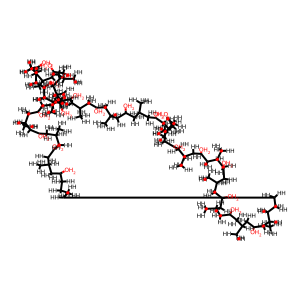

In [379]:
atoms = read('./setup/polymer.data', format='lammps-data')
bond_list = Bonds(atoms.get_array("bonds"))
g = create_graph(atoms)

result = longest_c_path(g)
print("Longest Path:", len(result))
print("Start Node Index:", result[0])
print("End Node Index:", result[-1])

atom_begin = atoms[result[0]]
atom_end = atoms[result[-1]]
vector = atom_end.position - atom_begin.position

atoms.positions = (atoms.positions - atom_begin.position)
atoms.positions = rotation(vector, atoms.positions)
atoms = create_cell(atoms, result[0], result[-1])
view(atoms)
print(atoms.get_number_of_atoms())

mol = atoms_to_mol(atoms)
mol = connect_head_tail(mol, result[0], result[-1])
print(mol.GetNumAtoms())
Chem.Draw.MolToImage(mol)
# mol

In [380]:
Chem.MolToPDBFile(mol, "tran_polymer.pdb", flavor=2)

In [381]:
class StructureTansformer:
    def __init__(self, atoms: Atoms):
        self.atoms = atoms
        
    def create_graph(self):
        """Create node-edge graph of ase atoms object,
        nodes are atoms and edges are bond,
        is used to find longest carbon backbone
        """
        G = nx.Graph()
        bond_list = Bonds(self.atoms.get_array("bonds"))
        for i in range(len(self.atoms)):
            G.add_node(i, atom_type=self.atoms.get_chemical_symbols()[i])
            
        for i in range(len(atoms)):
            for j in range(i + 1, len(self.atoms)):
                for k in bond_list:
                    if i in k and j in k:
                        G.add_edge(i, j, weight=1)
        return G
    
    def longest_c_path(self, label='C'):
        graph = self.create_graph()
        # Step 1: Identify nodes labeled as 'C'
        c_nodes = [idx for idx, type in graph.nodes(data=True) if type['atom_type'] == label]
        # Step 2: Create a subgraph of only nodes labeled 'C'
        c_subgraph = graph.subgraph(c_nodes)
        # Step 3: Find all simple paths and track the longest one
        longest_path = []
        for node in c_subgraph.nodes:
            for target in c_subgraph.nodes:
                if node != target:
                    try:
                        path = nx.shortest_path(c_subgraph, source=node, target=target)
                        if len(path) > len(longest_path):
                            longest_path = path
                    except nx.NetworkXNoPath:
                        continue
        # Step 4: Return the longest path and its start/end node indices
        if longest_path:
            return longest_path, longest_path[0], longest_path[-1]
        else:
            return [], None, None
    
    def rotation(self, vector, matrix):
        """Rotate the x-axis towards the vector position 
        and transform matrix accordingly
        """  
        def Ry(theta):
            return np.matrix([[ m.cos(theta), 0, m.sin(theta)],
                        [ 0           , 1, 0           ],
                        [-m.sin(theta), 0, m.cos(theta)]])
    
        def Rz(theta):
            return np.matrix([[ m.cos(theta), -m.sin(theta), 0 ],
                        [ m.sin(theta), m.cos(theta) , 0 ],
                        [ 0           , 0            , 1 ]])
        vector_xy = [vector[0], vector[1], 0]
        vector_x = [1, 0, 0]
        thetaz = np.arccos(np.dot(vector_xy, vector_x)/(np.linalg.norm(vector_xy)*np.linalg.norm(vector_x)))
        thetay = np.arccos(np.dot(vector_xy, vector)/(np.linalg.norm(vector_xy)*np.linalg.norm(vector)))
        return np.dot(np.dot(matrix, Rz(thetaz)), Ry(thetay))
    
    def atoms_to_mol(self):
        """Transform atoms object from ase to Rdkit mol object
        """
        bond_list = Bonds(self.atoms.get_array("bonds"))
        mol = Chem.RWMol()
        for z in self.atoms.get_atomic_numbers():
            mol.AddAtom(Chem.Atom(int(z)))
        conformer = Chem.Conformer(len(self.atoms))
        
        for i, pos in enumerate(self.atoms.positions):
            conformer.SetAtomPosition(i, pos)  
                   
        for bond in bond_list:
            mol.AddBond(bond[0], bond[1])
            
        mol.AddConformer(conformer)
        return mol
    
    def cell_creation(self, atoms: Atoms, begin_idx: int, end_idx: int):
        """create a cell that can include all atoms within it 
        except x direction which will be use for atom connection
        """
        cellx = atoms[begin_idx].position[0] - atoms[end_idx].position[0]
        celly = max(atoms.positions[:,1]) - min(atoms.positions[:,1])
        cellz = max(atoms.positions[:,2]) - min(atoms.positions[:,2])
        atoms.positions = atoms.positions + [0, -min(atoms.positions[:,1]), -min(atoms.positions[:,2])]
        atoms.cell = [cellx, celly, cellz]
        return atoms
    

In [382]:
tran = StructureTansformer(atoms)
tran.longest_c_path()
mol = tran.atoms_to_mol()